In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

c:\Users\tonyi\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [48]:
def get_data(year, month, start_day, start_hour, end_day, end_hour, directions):
    year_string = str(year)
    url = f'https://psl.noaa.gov/thredds/catalog/Datasets/cpc_global_precip/catalog.html?dataset=Datasets/cpc_global_precip/precip.{year_string}.nc'
    tds_catalog = TDSCatalog(url)
    ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
    ds = xr.open_dataset(ds_url).metpy.parse_cf()
    first_time = pd.Timestamp(year, month, start_day, start_hour)
    last_time = pd.Timestamp(year, month, end_day, end_hour)
    ds_timesliced = ds.sel(time=slice(first_time, last_time))
    ds_sliced = ds_timesliced.sel(lat=slice(directions['North'], directions['South']), lon=slice(directions['West'], directions['East']))

    return ds_sliced

def plot_data(ds, directions):
    time = ds.time.values
    int_datetime_index = pd.DatetimeIndex([time])


    levels = [0.3, 2.5, 6.4, 12.7, 19.1, 25.4, 38.1, 50.8, 63.5, 76.2]
    colors = ['white', '#95cbd5', '#6f98d0', '#45539e', '#8fbf5c', '#80ba55', '#568a4c', '#e4e44e', '#dcba60', '#d08c39', '#c43b33']
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(levels, cmap.N)


    # Create the figure 
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    precip = ax.contourf(ds['lon'], ds['lat'], ds.precip[0,:,:], levels=levels, cmap=cmap, extend='both', norm=norm)
    plt.colorbar(precip, ax=ax, orientation='vertical', label='mm/day', fraction=0.046, pad=0.04)


    ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, color='white')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, color='#fbf5e9')


    # Creating the legend with the custom entries

    #plt.xlabel('Longitude')
    #plt.ylabel('Pressure (hPa)')
    plt.title('ERA5 Reanalysis Vertical Cross-Section of Potential Vorticity and Potential Temperature')

    plt.show()

def plot_data2(ds, directions):
    time = ds.time.values
    int_datetime_index = pd.DatetimeIndex([time])


    levels = [0.3, 2.5, 6.4, 12.7, 19.1, 25.4, 38.1, 50.8, 63.5, 76.2]
    colors = ['white', '#95cbd5', '#6f98d0', '#45539e', '#8fbf5c', '#80ba55', '#568a4c', '#e4e44e', '#dcba60', '#d08c39', '#c43b33']
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(levels, cmap.N)


    # Create the figure 
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    precip = ax.pcolormesh(ds['lon'], ds['lat'], ds.precip[0,:,:], cmap=cmap, norm=norm)
    plt.colorbar(precip, ax=ax, orientation='vertical', label='mm/day', fraction=0.046, pad=0.04)


    ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, color='white')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, color='#fbf5e9')


    # Creating the legend with the custom entries

    #plt.xlabel('Longitude')
    #plt.ylabel('Pressure (hPa)')
    plt.title('ERA5 Reanalysis Vertical Cross-Section of Potential Vorticity and Potential Temperature')

    plt.show()

c:\Users\tonyi\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://psl.noaa.gov/thredds/catalog/Datasets/cpc_global_precip/catalog.html?dataset=Datasets/cpc_global_precip/precip.2019.nc returned HTML. Changing to: https://psl.noaa.gov/thredds/catalog/Datasets/cpc_global_precip/catalog.xml?dataset=Datasets/cpc_global_precip/precip.2019.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


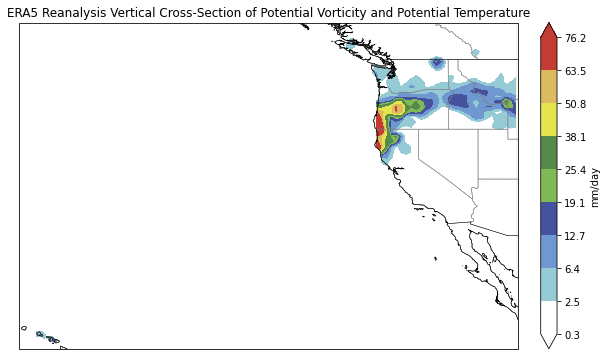

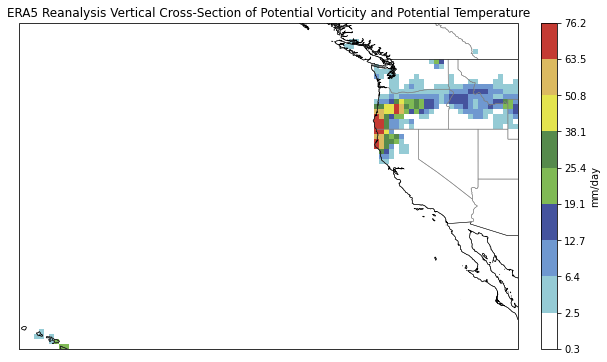

In [49]:
if __name__ == '__main__':
    directions = {'North': 55, 
                  'East': 250, 
                  'South': 20, 
                  'West': 200} #units: degrees North, degrees East
    year = 2019
    month = 2
    start_day = 25
    start_hour = 0
    end_day = 25
    end_hour = 23
    year_string = str(year)

    ds = get_data(year, month, start_day, start_hour, end_day, end_hour, directions)
    plot_data(ds, directions)
    plot_data2(ds, directions)
